http://repositorium.sdum.uminho.pt/bitstream/1822/30994/1/dss-v3.pdf

In [1]:
#need to install lightgbm from anacondra prompt

In [63]:
#Data Preparation
#We will now import some required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

In [64]:
#Loading the dataset
dataset = pd.read_csv('bank-additional-full_copy.csv',delimiter=";")
dataset = dataset.drop(['duration'], axis=1)
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [65]:
dataset.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [66]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 6.3+ MB


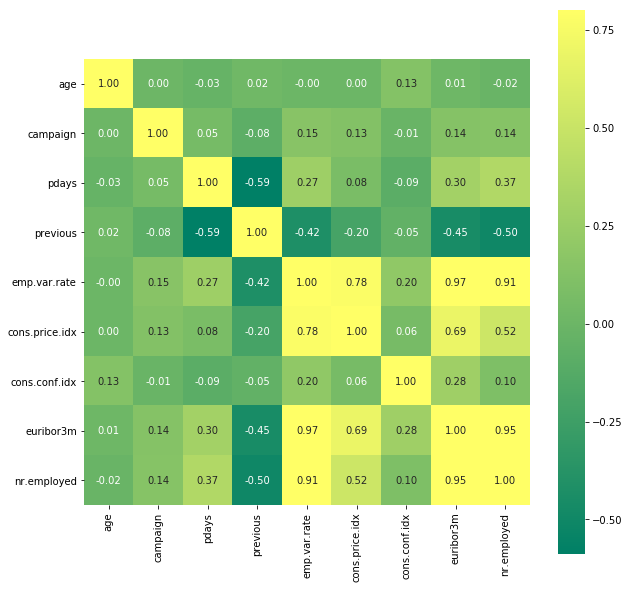

In [67]:
corrmat = dataset.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap = "summer")
plt.show()

In [68]:
# Check for null values. 
dataset.isnull().sum().sort_values(ascending=False)

y                 0
nr.employed       0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
age               0
dtype: int64

In [69]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
 
features = []; categorical_features = []
num_of_columns = dataset.shape[1]
 
for i in range(0, num_of_columns):
 column_name = dataset.columns[i]
 column_type = dataset[column_name].dtypes
 
 if i != num_of_columns - 1: #skip target
  features.append(column_name)
 
 if column_type == 'object':
  le.fit(dataset[column_name])
  feature_classes = list(le.classes_)
  encoded_feature = le.transform(dataset[column_name])
  dataset[column_name] = pd.DataFrame(encoded_feature)
 
  if i != num_of_columns - 1: #skip target
   categorical_features.append(column_name)

In [70]:
# splitting data
X = dataset.drop(['y'], axis=1)
y = dataset['y']

In [44]:
#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)
X_train.shape

(35009, 19)

In [71]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 70)


param_grid = {
    'n_estimators': [x for x in range(20, 100, 4)],
    'learning_rate': [0.05, 0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

C:\Users\barba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's auc: 0.774768	valid_0's binary_logloss: 0.340848	valid_0's l1: 0.197429
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779045	valid_0's binary_logloss: 0.332773	valid_0's l1: 0.195243
[3]	valid_0's auc: 0.778827	valid_0's binary_logloss: 0.326289	valid_0's l1: 0.193211
[4]	valid_0's auc: 0.779637	valid_0's binary_logloss: 0.320523	valid_0's l1: 0.191179
[5]	valid_0's auc: 0.780097	valid_0's binary_logloss: 0.31571	valid_0's l1: 0.189312
[6]	valid_0's auc: 0.781494	valid_0's binary_logloss: 0.31156	valid_0's l1: 0.187518
[7]	valid_0's auc: 0.785012	valid_0's binary_logloss: 0.307679	valid_0's l1: 0.18578
[8]	valid_0's auc: 0.784954	valid_0's binary_logloss: 0.304546	valid_0's l1: 0.184201
[9]	valid_0's auc: 0.784981	valid_0's binary_logloss: 0.301583	valid_0's l1: 0.182616
[10]	valid_0's auc: 0.786101	valid_0's binary_logloss: 0.298943	valid_0's l1: 0.181131
[11]	valid_0's auc: 0.791759	valid_0's binary_logloss: 0.296513	valid_0's l1: 0.1

[7]	valid_0's auc: 0.785012	valid_0's binary_logloss: 0.307679	valid_0's l1: 0.18578
[8]	valid_0's auc: 0.784954	valid_0's binary_logloss: 0.304546	valid_0's l1: 0.184201
[9]	valid_0's auc: 0.784981	valid_0's binary_logloss: 0.301583	valid_0's l1: 0.182616
[10]	valid_0's auc: 0.786101	valid_0's binary_logloss: 0.298943	valid_0's l1: 0.181131
[11]	valid_0's auc: 0.791759	valid_0's binary_logloss: 0.296513	valid_0's l1: 0.179691
[12]	valid_0's auc: 0.79205	valid_0's binary_logloss: 0.294406	valid_0's l1: 0.178384
[13]	valid_0's auc: 0.792831	valid_0's binary_logloss: 0.29241	valid_0's l1: 0.177116
[14]	valid_0's auc: 0.793892	valid_0's binary_logloss: 0.290658	valid_0's l1: 0.175894
[15]	valid_0's auc: 0.792773	valid_0's binary_logloss: 0.289087	valid_0's l1: 0.174748
[16]	valid_0's auc: 0.793277	valid_0's binary_logloss: 0.287982	valid_0's l1: 0.173757
[17]	valid_0's auc: 0.793103	valid_0's binary_logloss: 0.286778	valid_0's l1: 0.172752
[18]	valid_0's auc: 0.792908	valid_0's binary_log

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.340635	valid_0's l1: 0.197278
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784954	valid_0's binary_logloss: 0.332105	valid_0's l1: 0.194916
[3]	valid_0's auc: 0.788546	valid_0's binary_logloss: 0.325171	valid_0's l1: 0.192701
[4]	valid_0's auc: 0.786542	valid_0's binary_logloss: 0.319348	valid_0's l1: 0.190602
[5]	valid_0's auc: 0.791604	valid_0's binary_logloss: 0.314205	valid_0's l1: 0.188606
[6]	valid_0's auc: 0.798089	valid_0's binary_logloss: 0.309618	valid_0's l1: 0.186675
[7]	valid_0's auc: 0.796425	valid_0's binary_logloss: 0.305823	valid_0's l1: 0.184918
[8]	valid_0's auc: 0.797162	valid_0's binary_logloss: 0.302287	valid_0's l1: 0.183183
[9]	valid_0's auc: 0.799199	valid_0's binary_logloss: 0.29922	valid_0's l1: 0.181539
[10]	valid_0's auc: 0.799808	valid_0's binary_logloss: 0.296438	valid_0's l1: 0.179973
[11]	valid_0's auc: 0.797735	valid_0's binary_logloss: 0.29395	valid_0's l1: 0.

[1]	valid_0's auc: 0.786426	valid_0's binary_logloss: 0.34051	valid_0's l1: 0.197315
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783858	valid_0's binary_logloss: 0.332439	valid_0's l1: 0.195095
[3]	valid_0's auc: 0.784008	valid_0's binary_logloss: 0.325649	valid_0's l1: 0.192989
[4]	valid_0's auc: 0.784287	valid_0's binary_logloss: 0.319943	valid_0's l1: 0.19099
[5]	valid_0's auc: 0.784771	valid_0's binary_logloss: 0.315137	valid_0's l1: 0.18907
[6]	valid_0's auc: 0.785988	valid_0's binary_logloss: 0.310917	valid_0's l1: 0.187245
Early stopping, best iteration is:
[1]	valid_0's auc: 0.786426	valid_0's binary_logloss: 0.34051	valid_0's l1: 0.197315
[1]	valid_0's auc: 0.774768	valid_0's binary_logloss: 0.340848	valid_0's l1: 0.197429
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779045	valid_0's binary_logloss: 0.332773	valid_0's l1: 0.195243
[3]	valid_0's auc: 0.778827	valid_0's binary_logloss: 0.326289	valid_0's 

[9]	valid_0's auc: 0.784981	valid_0's binary_logloss: 0.301583	valid_0's l1: 0.182616
[10]	valid_0's auc: 0.786101	valid_0's binary_logloss: 0.298943	valid_0's l1: 0.181131
[11]	valid_0's auc: 0.791759	valid_0's binary_logloss: 0.296513	valid_0's l1: 0.179691
[12]	valid_0's auc: 0.79205	valid_0's binary_logloss: 0.294406	valid_0's l1: 0.178384
[13]	valid_0's auc: 0.792831	valid_0's binary_logloss: 0.29241	valid_0's l1: 0.177116
[14]	valid_0's auc: 0.793892	valid_0's binary_logloss: 0.290658	valid_0's l1: 0.175894
[15]	valid_0's auc: 0.792773	valid_0's binary_logloss: 0.289087	valid_0's l1: 0.174748
[16]	valid_0's auc: 0.793277	valid_0's binary_logloss: 0.287982	valid_0's l1: 0.173757
[17]	valid_0's auc: 0.793103	valid_0's binary_logloss: 0.286778	valid_0's l1: 0.172752
[18]	valid_0's auc: 0.792908	valid_0's binary_logloss: 0.285629	valid_0's l1: 0.171738
[19]	valid_0's auc: 0.791397	valid_0's binary_logloss: 0.284652	valid_0's l1: 0.17081
Early stopping, best iteration is:
[14]	valid_0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.340635	valid_0's l1: 0.197278
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784954	valid_0's binary_logloss: 0.332105	valid_0's l1: 0.194916
[3]	valid_0's auc: 0.788546	valid_0's binary_logloss: 0.325171	valid_0's l1: 0.192701
[4]	valid_0's auc: 0.786542	valid_0's binary_logloss: 0.319348	valid_0's l1: 0.190602
[5]	valid_0's auc: 0.791604	valid_0's binary_logloss: 0.314205	valid_0's l1: 0.188606
[6]	valid_0's auc: 0.798089	valid_0's binary_logloss: 0.309618	valid_0's l1: 0.186675
[7]	valid_0's auc: 0.796425	valid_0's binary_logloss: 0.305823	valid_0's l1: 0.184918
[8]	valid_0's auc: 0.797162	valid_0's binary_logloss: 0.302287	valid_0's l1: 0.183183
[9]	valid_0's auc: 0.799199	valid_0's binary_logloss: 0.29922	valid_0's l1: 0.181539
[10]	valid_0's auc: 0.799808	valid_0's binary_logloss: 0.296438	valid_0's l1: 0.179973
[11]	valid_0's auc: 0.797735	valid_0's binary_logloss: 0.29395	valid_0's l1: 0.

[1]	valid_0's auc: 0.786426	valid_0's binary_logloss: 0.34051	valid_0's l1: 0.197315
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783858	valid_0's binary_logloss: 0.332439	valid_0's l1: 0.195095
[3]	valid_0's auc: 0.784008	valid_0's binary_logloss: 0.325649	valid_0's l1: 0.192989
[4]	valid_0's auc: 0.784287	valid_0's binary_logloss: 0.319943	valid_0's l1: 0.19099
[5]	valid_0's auc: 0.784771	valid_0's binary_logloss: 0.315137	valid_0's l1: 0.18907
[6]	valid_0's auc: 0.785988	valid_0's binary_logloss: 0.310917	valid_0's l1: 0.187245
Early stopping, best iteration is:
[1]	valid_0's auc: 0.786426	valid_0's binary_logloss: 0.34051	valid_0's l1: 0.197315
[1]	valid_0's auc: 0.774768	valid_0's binary_logloss: 0.340848	valid_0's l1: 0.197429
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.779045	valid_0's binary_logloss: 0.332773	valid_0's l1: 0.195243
[3]	valid_0's auc: 0.778827	valid_0's binary_logloss: 0.326289	valid_0's 

[3]	valid_0's auc: 0.778827	valid_0's binary_logloss: 0.326289	valid_0's l1: 0.193211
[4]	valid_0's auc: 0.779637	valid_0's binary_logloss: 0.320523	valid_0's l1: 0.191179
[5]	valid_0's auc: 0.780097	valid_0's binary_logloss: 0.31571	valid_0's l1: 0.189312
[6]	valid_0's auc: 0.781494	valid_0's binary_logloss: 0.31156	valid_0's l1: 0.187518
[7]	valid_0's auc: 0.785012	valid_0's binary_logloss: 0.307679	valid_0's l1: 0.18578
[8]	valid_0's auc: 0.784954	valid_0's binary_logloss: 0.304546	valid_0's l1: 0.184201
[9]	valid_0's auc: 0.784981	valid_0's binary_logloss: 0.301583	valid_0's l1: 0.182616
[10]	valid_0's auc: 0.786101	valid_0's binary_logloss: 0.298943	valid_0's l1: 0.181131
[11]	valid_0's auc: 0.791759	valid_0's binary_logloss: 0.296513	valid_0's l1: 0.179691
[12]	valid_0's auc: 0.79205	valid_0's binary_logloss: 0.294406	valid_0's l1: 0.178384
[13]	valid_0's auc: 0.792831	valid_0's binary_logloss: 0.29241	valid_0's l1: 0.177116
[14]	valid_0's auc: 0.793892	valid_0's binary_logloss: 

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.340635	valid_0's l1: 0.197278
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784954	valid_0's binary_logloss: 0.332105	valid_0's l1: 0.194916
[3]	valid_0's auc: 0.788546	valid_0's binary_logloss: 0.325171	valid_0's l1: 0.192701
[4]	valid_0's auc: 0.786542	valid_0's binary_logloss: 0.319348	valid_0's l1: 0.190602
[5]	valid_0's auc: 0.791604	valid_0's binary_logloss: 0.314205	valid_0's l1: 0.188606
[6]	valid_0's auc: 0.798089	valid_0's binary_logloss: 0.309618	valid_0's l1: 0.186675
[7]	valid_0's auc: 0.796425	valid_0's binary_logloss: 0.305823	valid_0's l1: 0.184918
[8]	valid_0's auc: 0.797162	valid_0's binary_logloss: 0.302287	valid_0's l1: 0.183183
[9]	valid_0's auc: 0.799199	valid_0's binary_logloss: 0.29922	valid_0's l1: 0.181539
[10]	valid_0's auc: 0.799808	valid_0's binary_logloss: 0.296438	valid_0's l1: 0.179973
[11]	valid_0's auc: 0.797735	valid_0's binary_logloss: 0.29395	valid_0's l1: 0.

Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784844	valid_0's binary_logloss: 0.317875	valid_0's l1: 0.190628
[3]	valid_0's auc: 0.787286	valid_0's binary_logloss: 0.308872	valid_0's l1: 0.186827
[4]	valid_0's auc: 0.789531	valid_0's binary_logloss: 0.302043	valid_0's l1: 0.183349
[5]	valid_0's auc: 0.794401	valid_0's binary_logloss: 0.29663	valid_0's l1: 0.180152
[6]	valid_0's auc: 0.793945	valid_0's binary_logloss: 0.292374	valid_0's l1: 0.177299
[7]	valid_0's auc: 0.797813	valid_0's binary_logloss: 0.288649	valid_0's l1: 0.174806
[8]	valid_0's auc: 0.797321	valid_0's binary_logloss: 0.285915	valid_0's l1: 0.172523
[9]	valid_0's auc: 0.798999	valid_0's binary_logloss: 0.283587	valid_0's l1: 0.170595
[10]	valid_0's auc: 0.797342	valid_0's binary_logloss: 0.282097	valid_0's l1: 0.168916
[11]	valid_0's auc: 0.795752	valid_0's binary_logloss: 0.280682	valid_0's l1: 0.167323
[12]	valid_0's auc: 0.797076	valid_0's binary_logloss: 0.279254	valid_0's l1: 

[1]	valid_0's auc: 0.774768	valid_0's binary_logloss: 0.330889	valid_0's l1: 0.195105
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.777323	valid_0's binary_logloss: 0.318854	valid_0's l1: 0.191016
[3]	valid_0's auc: 0.781216	valid_0's binary_logloss: 0.310165	valid_0's l1: 0.187331
[4]	valid_0's auc: 0.784938	valid_0's binary_logloss: 0.303048	valid_0's l1: 0.183916
[5]	valid_0's auc: 0.795445	valid_0's binary_logloss: 0.297219	valid_0's l1: 0.180753
[6]	valid_0's auc: 0.796081	valid_0's binary_logloss: 0.292905	valid_0's l1: 0.178033
[7]	valid_0's auc: 0.794035	valid_0's binary_logloss: 0.289493	valid_0's l1: 0.175579
[8]	valid_0's auc: 0.792985	valid_0's binary_logloss: 0.286952	valid_0's l1: 0.173418
[9]	valid_0's auc: 0.792175	valid_0's binary_logloss: 0.284778	valid_0's l1: 0.17143
[10]	valid_0's auc: 0.793157	valid_0's binary_logloss: 0.282865	valid_0's l1: 0.169595
[11]	valid_0's auc: 0.794346	valid_0's binary_logloss: 0.281353	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.330456	valid_0's l1: 0.194747
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788915	valid_0's binary_logloss: 0.317292	valid_0's l1: 0.190286
[3]	valid_0's auc: 0.789929	valid_0's binary_logloss: 0.308122	valid_0's l1: 0.186423
[4]	valid_0's auc: 0.798605	valid_0's binary_logloss: 0.300494	valid_0's l1: 0.182771
[5]	valid_0's auc: 0.800253	valid_0's binary_logloss: 0.295212	valid_0's l1: 0.179652
[6]	valid_0's auc: 0.796255	valid_0's binary_logloss: 0.29059	valid_0's l1: 0.176729
[7]	valid_0's auc: 0.796992	valid_0's binary_logloss: 0.286998	valid_0's l1: 0.174117
[8]	valid_0's auc: 0.798026	valid_0's binary_logloss: 0.283989	valid_0's l1: 0.171802
[9]	valid_0's auc: 0.798398	valid_0's binary_logloss: 0.281546	valid_0's l1: 0.169684
[10]	valid_0's auc: 0.79908	valid_0's binary_logloss: 0.279597	valid_0's l1: 0.1677
Early stopping, best iteration is:
[5]	valid_0's auc: 0.800253	valid_0's binary_lo

[1]	valid_0's auc: 0.774768	valid_0's binary_logloss: 0.330889	valid_0's l1: 0.195105
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.777323	valid_0's binary_logloss: 0.318854	valid_0's l1: 0.191016
[3]	valid_0's auc: 0.781216	valid_0's binary_logloss: 0.310165	valid_0's l1: 0.187331
[4]	valid_0's auc: 0.784938	valid_0's binary_logloss: 0.303048	valid_0's l1: 0.183916
[5]	valid_0's auc: 0.795445	valid_0's binary_logloss: 0.297219	valid_0's l1: 0.180753
[6]	valid_0's auc: 0.796081	valid_0's binary_logloss: 0.292905	valid_0's l1: 0.178033
[7]	valid_0's auc: 0.794035	valid_0's binary_logloss: 0.289493	valid_0's l1: 0.175579
[8]	valid_0's auc: 0.792985	valid_0's binary_logloss: 0.286952	valid_0's l1: 0.173418
[9]	valid_0's auc: 0.792175	valid_0's binary_logloss: 0.284778	valid_0's l1: 0.17143
[10]	valid_0's auc: 0.793157	valid_0's binary_logloss: 0.282865	valid_0's l1: 0.169595
[11]	valid_0's auc: 0.794346	valid_0's binary_logloss: 0.281353	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.330456	valid_0's l1: 0.194747
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788915	valid_0's binary_logloss: 0.317292	valid_0's l1: 0.190286
[3]	valid_0's auc: 0.789929	valid_0's binary_logloss: 0.308122	valid_0's l1: 0.186423
[4]	valid_0's auc: 0.798605	valid_0's binary_logloss: 0.300494	valid_0's l1: 0.182771
[5]	valid_0's auc: 0.800253	valid_0's binary_logloss: 0.295212	valid_0's l1: 0.179652
[6]	valid_0's auc: 0.796255	valid_0's binary_logloss: 0.29059	valid_0's l1: 0.176729
[7]	valid_0's auc: 0.796992	valid_0's binary_logloss: 0.286998	valid_0's l1: 0.174117
[8]	valid_0's auc: 0.798026	valid_0's binary_logloss: 0.283989	valid_0's l1: 0.171802
[9]	valid_0's auc: 0.798398	valid_0's binary_logloss: 0.281546	valid_0's l1: 0.169684
[10]	valid_0's auc: 0.79908	valid_0's binary_logloss: 0.279597	valid_0's l1: 0.1677
Early stopping, best iteration is:
[5]	valid_0's auc: 0.800253	valid_0's binary_lo

[1]	valid_0's auc: 0.774768	valid_0's binary_logloss: 0.330889	valid_0's l1: 0.195105
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.777323	valid_0's binary_logloss: 0.318854	valid_0's l1: 0.191016
[3]	valid_0's auc: 0.781216	valid_0's binary_logloss: 0.310165	valid_0's l1: 0.187331
[4]	valid_0's auc: 0.784938	valid_0's binary_logloss: 0.303048	valid_0's l1: 0.183916
[5]	valid_0's auc: 0.795445	valid_0's binary_logloss: 0.297219	valid_0's l1: 0.180753
[6]	valid_0's auc: 0.796081	valid_0's binary_logloss: 0.292905	valid_0's l1: 0.178033
[7]	valid_0's auc: 0.794035	valid_0's binary_logloss: 0.289493	valid_0's l1: 0.175579
[8]	valid_0's auc: 0.792985	valid_0's binary_logloss: 0.286952	valid_0's l1: 0.173418
[9]	valid_0's auc: 0.792175	valid_0's binary_logloss: 0.284778	valid_0's l1: 0.17143
[10]	valid_0's auc: 0.793157	valid_0's binary_logloss: 0.282865	valid_0's l1: 0.169595
[11]	valid_0's auc: 0.794346	valid_0's binary_logloss: 0.281353	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.330456	valid_0's l1: 0.194747
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788915	valid_0's binary_logloss: 0.317292	valid_0's l1: 0.190286
[3]	valid_0's auc: 0.789929	valid_0's binary_logloss: 0.308122	valid_0's l1: 0.186423
[4]	valid_0's auc: 0.798605	valid_0's binary_logloss: 0.300494	valid_0's l1: 0.182771
[5]	valid_0's auc: 0.800253	valid_0's binary_logloss: 0.295212	valid_0's l1: 0.179652
[6]	valid_0's auc: 0.796255	valid_0's binary_logloss: 0.29059	valid_0's l1: 0.176729
[7]	valid_0's auc: 0.796992	valid_0's binary_logloss: 0.286998	valid_0's l1: 0.174117
[8]	valid_0's auc: 0.798026	valid_0's binary_logloss: 0.283989	valid_0's l1: 0.171802
[9]	valid_0's auc: 0.798398	valid_0's binary_logloss: 0.281546	valid_0's l1: 0.169684
[10]	valid_0's auc: 0.79908	valid_0's binary_logloss: 0.279597	valid_0's l1: 0.1677
Early stopping, best iteration is:
[5]	valid_0's auc: 0.800253	valid_0's binary_lo

[1]	valid_0's auc: 0.774768	valid_0's binary_logloss: 0.330889	valid_0's l1: 0.195105
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.777323	valid_0's binary_logloss: 0.318854	valid_0's l1: 0.191016
[3]	valid_0's auc: 0.781216	valid_0's binary_logloss: 0.310165	valid_0's l1: 0.187331
[4]	valid_0's auc: 0.784938	valid_0's binary_logloss: 0.303048	valid_0's l1: 0.183916
[5]	valid_0's auc: 0.795445	valid_0's binary_logloss: 0.297219	valid_0's l1: 0.180753
[6]	valid_0's auc: 0.796081	valid_0's binary_logloss: 0.292905	valid_0's l1: 0.178033
[7]	valid_0's auc: 0.794035	valid_0's binary_logloss: 0.289493	valid_0's l1: 0.175579
[8]	valid_0's auc: 0.792985	valid_0's binary_logloss: 0.286952	valid_0's l1: 0.173418
[9]	valid_0's auc: 0.792175	valid_0's binary_logloss: 0.284778	valid_0's l1: 0.17143
[10]	valid_0's auc: 0.793157	valid_0's binary_logloss: 0.282865	valid_0's l1: 0.169595
[11]	valid_0's auc: 0.794346	valid_0's binary_logloss: 0.281353	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783733	valid_0's binary_logloss: 0.325667	valid_0's l1: 0.193462
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788719	valid_0's binary_logloss: 0.311548	valid_0's l1: 0.188211
[3]	valid_0's auc: 0.799296	valid_0's binary_logloss: 0.301402	valid_0's l1: 0.183525
[4]	valid_0's auc: 0.799418	valid_0's binary_logloss: 0.294248	valid_0's l1: 0.179426
[5]	valid_0's auc: 0.799183	valid_0's binary_logloss: 0.289063	valid_0's l1: 0.175866
[6]	valid_0's auc: 0.800563	valid_0's binary_logloss: 0.284926	valid_0's l1: 0.172695
[7]	valid_0's auc: 0.799708	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.169924
[8]	valid_0's auc: 0.799925	valid_0's binary_logloss: 0.279392	valid_0's l1: 0.167501
[9]	valid_0's auc: 0.800794	valid_0's binary_logloss: 0.27769	valid_0's l1: 0.165389
[10]	valid_0's auc: 0.801921	valid_0's binary_logloss: 0.276206	valid_0's l1: 0.163551
[11]	valid_0's auc: 0.804382	valid_0's binary_logloss: 0.274986	valid_0's l1: 0

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.3211	valid_0's l1: 0.192165
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782845	valid_0's binary_logloss: 0.306455	valid_0's l1: 0.186047
[3]	valid_0's auc: 0.797788	valid_0's binary_logloss: 0.296285	valid_0's l1: 0.180796
[4]	valid_0's auc: 0.798135	valid_0's binary_logloss: 0.289448	valid_0's l1: 0.176347
[5]	valid_0's auc: 0.795651	valid_0's binary_logloss: 0.284717	valid_0's l1: 0.172696
[6]	valid_0's auc: 0.796852	valid_0's binary_logloss: 0.281368	valid_0's l1: 0.169512
[7]	valid_0's auc: 0.798433	valid_0's binary_logloss: 0.278706	valid_0's l1: 0.166699
[8]	valid_0's auc: 0.79922	valid_0's binary_logloss: 0.277017	valid_0's l1: 0.164322
[9]	valid_0's auc: 0.800883	valid_0's binary_logloss: 0.275554	valid_0's l1: 0.162324
[10]	valid_0's auc: 0.80148	valid_0's binary_logloss: 0.274511	valid_0's l1: 0.160524
[11]	valid_0's auc: 0.80091	valid_0's binary_logloss: 0.273886	valid_0's l1: 0.159

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783735	valid_0's binary_logloss: 0.31677	valid_0's l1: 0.190857
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786519	valid_0's binary_logloss: 0.301861	valid_0's l1: 0.184014
[3]	valid_0's auc: 0.797291	valid_0's binary_logloss: 0.292302	valid_0's l1: 0.178299
[4]	valid_0's auc: 0.79581	valid_0's binary_logloss: 0.285821	valid_0's l1: 0.17355
[5]	valid_0's auc: 0.798515	valid_0's binary_logloss: 0.281211	valid_0's l1: 0.169439
[6]	valid_0's auc: 0.798827	valid_0's binary_logloss: 0.278311	valid_0's l1: 0.166224
[7]	valid_0's auc: 0.79959	valid_0's binary_logloss: 0.276184	valid_0's l1: 0.163517
[8]	valid_0's auc: 0.799475	valid_0's binary_logloss: 0.275181	valid_0's l1: 0.161466
[9]	valid_0's auc: 0.800837	valid_0's binary_logloss: 0.274373	valid_0's l1: 0.1597
[10]	valid_0's auc: 0.799609	valid_0's binary_logloss: 0.273997	valid_0's l1: 0.158141
[11]	valid_0's auc: 0.798943	valid_0's binary_logloss: 0.273592	valid_0's l1: 0.1569

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.312691	valid_0's l1: 0.189541
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788653	valid_0's binary_logloss: 0.297704	valid_0's l1: 0.182051
[3]	valid_0's auc: 0.796496	valid_0's binary_logloss: 0.288399	valid_0's l1: 0.175914
[4]	valid_0's auc: 0.79894	valid_0's binary_logloss: 0.282221	valid_0's l1: 0.170815
[5]	valid_0's auc: 0.798718	valid_0's binary_logloss: 0.278334	valid_0's l1: 0.166656
[6]	valid_0's auc: 0.798019	valid_0's binary_logloss: 0.27633	valid_0's l1: 0.163517
[7]	valid_0's auc: 0.798351	valid_0's binary_logloss: 0.27506	valid_0's l1: 0.1611
[8]	valid_0's auc: 0.797477	valid_0's binary_logloss: 0.274186	valid_0's l1: 0.159079
[9]	valid_0's auc: 0.797433	valid_0's binary_logloss: 0.273604	valid_0's l1: 0.15733
Early stopping, best iteration is:
[4]	valid_0's auc: 0.79894	valid_0's binary_logloss: 0.282221	valid_0's l1: 0.170815
[1]	valid_0's auc: 0.786426	valid_0's binary_loglos

[1]	valid_0's auc: 0.774767	valid_0's binary_logloss: 0.313577	valid_0's l1: 0.190395
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784672	valid_0's binary_logloss: 0.299932	valid_0's l1: 0.183354
[3]	valid_0's auc: 0.783404	valid_0's binary_logloss: 0.292266	valid_0's l1: 0.177825
[4]	valid_0's auc: 0.790452	valid_0's binary_logloss: 0.286479	valid_0's l1: 0.173178
[5]	valid_0's auc: 0.790699	valid_0's binary_logloss: 0.282456	valid_0's l1: 0.169229
[6]	valid_0's auc: 0.794536	valid_0's binary_logloss: 0.279859	valid_0's l1: 0.166234
[7]	valid_0's auc: 0.796923	valid_0's binary_logloss: 0.278167	valid_0's l1: 0.164009
[8]	valid_0's auc: 0.798027	valid_0's binary_logloss: 0.277427	valid_0's l1: 0.162072
[9]	valid_0's auc: 0.796791	valid_0's binary_logloss: 0.276427	valid_0's l1: 0.160135
[10]	valid_0's auc: 0.79866	valid_0's binary_logloss: 0.275819	valid_0's l1: 0.158975
[11]	valid_0's auc: 0.797276	valid_0's binary_logloss: 0.27558	valid_0's l1: 0.

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.312691	valid_0's l1: 0.189541
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788653	valid_0's binary_logloss: 0.297704	valid_0's l1: 0.182051
[3]	valid_0's auc: 0.796496	valid_0's binary_logloss: 0.288399	valid_0's l1: 0.175914
[4]	valid_0's auc: 0.79894	valid_0's binary_logloss: 0.282221	valid_0's l1: 0.170815
[5]	valid_0's auc: 0.798718	valid_0's binary_logloss: 0.278334	valid_0's l1: 0.166656
[6]	valid_0's auc: 0.798019	valid_0's binary_logloss: 0.27633	valid_0's l1: 0.163517
[7]	valid_0's auc: 0.798351	valid_0's binary_logloss: 0.27506	valid_0's l1: 0.1611
[8]	valid_0's auc: 0.797477	valid_0's binary_logloss: 0.274186	valid_0's l1: 0.159079
[9]	valid_0's auc: 0.797433	valid_0's binary_logloss: 0.273604	valid_0's l1: 0.15733
Early stopping, best iteration is:
[4]	valid_0's auc: 0.79894	valid_0's binary_logloss: 0.282221	valid_0's l1: 0.170815
[1]	valid_0's auc: 0.786426	valid_0's binary_loglos

[1]	valid_0's auc: 0.774767	valid_0's binary_logloss: 0.313577	valid_0's l1: 0.190395
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784672	valid_0's binary_logloss: 0.299932	valid_0's l1: 0.183354
[3]	valid_0's auc: 0.783404	valid_0's binary_logloss: 0.292266	valid_0's l1: 0.177825
[4]	valid_0's auc: 0.790452	valid_0's binary_logloss: 0.286479	valid_0's l1: 0.173178
[5]	valid_0's auc: 0.790699	valid_0's binary_logloss: 0.282456	valid_0's l1: 0.169229
[6]	valid_0's auc: 0.794536	valid_0's binary_logloss: 0.279859	valid_0's l1: 0.166234
[7]	valid_0's auc: 0.796923	valid_0's binary_logloss: 0.278167	valid_0's l1: 0.164009
[8]	valid_0's auc: 0.798027	valid_0's binary_logloss: 0.277427	valid_0's l1: 0.162072
[9]	valid_0's auc: 0.796791	valid_0's binary_logloss: 0.276427	valid_0's l1: 0.160135
[10]	valid_0's auc: 0.79866	valid_0's binary_logloss: 0.275819	valid_0's l1: 0.158975
[11]	valid_0's auc: 0.797276	valid_0's binary_logloss: 0.27558	valid_0's l1: 0.

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.312691	valid_0's l1: 0.189541
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788653	valid_0's binary_logloss: 0.297704	valid_0's l1: 0.182051
[3]	valid_0's auc: 0.796496	valid_0's binary_logloss: 0.288399	valid_0's l1: 0.175914
[4]	valid_0's auc: 0.79894	valid_0's binary_logloss: 0.282221	valid_0's l1: 0.170815
[5]	valid_0's auc: 0.798718	valid_0's binary_logloss: 0.278334	valid_0's l1: 0.166656
[6]	valid_0's auc: 0.798019	valid_0's binary_logloss: 0.27633	valid_0's l1: 0.163517
[7]	valid_0's auc: 0.798351	valid_0's binary_logloss: 0.27506	valid_0's l1: 0.1611
[8]	valid_0's auc: 0.797477	valid_0's binary_logloss: 0.274186	valid_0's l1: 0.159079
[9]	valid_0's auc: 0.797433	valid_0's binary_logloss: 0.273604	valid_0's l1: 0.15733
Early stopping, best iteration is:
[4]	valid_0's auc: 0.79894	valid_0's binary_logloss: 0.282221	valid_0's l1: 0.170815
[1]	valid_0's auc: 0.786426	valid_0's binary_loglos

[1]	valid_0's auc: 0.774767	valid_0's binary_logloss: 0.313577	valid_0's l1: 0.190395
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784672	valid_0's binary_logloss: 0.299932	valid_0's l1: 0.183354
[3]	valid_0's auc: 0.783404	valid_0's binary_logloss: 0.292266	valid_0's l1: 0.177825
[4]	valid_0's auc: 0.790452	valid_0's binary_logloss: 0.286479	valid_0's l1: 0.173178
[5]	valid_0's auc: 0.790699	valid_0's binary_logloss: 0.282456	valid_0's l1: 0.169229
[6]	valid_0's auc: 0.794536	valid_0's binary_logloss: 0.279859	valid_0's l1: 0.166234
[7]	valid_0's auc: 0.796923	valid_0's binary_logloss: 0.278167	valid_0's l1: 0.164009
[8]	valid_0's auc: 0.798027	valid_0's binary_logloss: 0.277427	valid_0's l1: 0.162072
[9]	valid_0's auc: 0.796791	valid_0's binary_logloss: 0.276427	valid_0's l1: 0.160135
[10]	valid_0's auc: 0.79866	valid_0's binary_logloss: 0.275819	valid_0's l1: 0.158975
[11]	valid_0's auc: 0.797276	valid_0's binary_logloss: 0.27558	valid_0's l1: 0.

[1]	valid_0's auc: 0.783736	valid_0's binary_logloss: 0.312691	valid_0's l1: 0.189541
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.788653	valid_0's binary_logloss: 0.297704	valid_0's l1: 0.182051
[3]	valid_0's auc: 0.796496	valid_0's binary_logloss: 0.288399	valid_0's l1: 0.175914
[4]	valid_0's auc: 0.79894	valid_0's binary_logloss: 0.282221	valid_0's l1: 0.170815
[5]	valid_0's auc: 0.798718	valid_0's binary_logloss: 0.278334	valid_0's l1: 0.166656
[6]	valid_0's auc: 0.798019	valid_0's binary_logloss: 0.27633	valid_0's l1: 0.163517
[7]	valid_0's auc: 0.798351	valid_0's binary_logloss: 0.27506	valid_0's l1: 0.1611
[8]	valid_0's auc: 0.797477	valid_0's binary_logloss: 0.274186	valid_0's l1: 0.159079
[9]	valid_0's auc: 0.797433	valid_0's binary_logloss: 0.273604	valid_0's l1: 0.15733
Early stopping, best iteration is:
[4]	valid_0's auc: 0.79894	valid_0's binary_logloss: 0.282221	valid_0's l1: 0.170815
[1]	valid_0's auc: 0.786426	valid_0's binary_loglos

[1]	valid_0's auc: 0.774767	valid_0's binary_logloss: 0.313577	valid_0's l1: 0.190395
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.784672	valid_0's binary_logloss: 0.299932	valid_0's l1: 0.183354
[3]	valid_0's auc: 0.783404	valid_0's binary_logloss: 0.292266	valid_0's l1: 0.177825
[4]	valid_0's auc: 0.790452	valid_0's binary_logloss: 0.286479	valid_0's l1: 0.173178
[5]	valid_0's auc: 0.790699	valid_0's binary_logloss: 0.282456	valid_0's l1: 0.169229
[6]	valid_0's auc: 0.794536	valid_0's binary_logloss: 0.279859	valid_0's l1: 0.166234
[7]	valid_0's auc: 0.796923	valid_0's binary_logloss: 0.278167	valid_0's l1: 0.164009
[8]	valid_0's auc: 0.798027	valid_0's binary_logloss: 0.277427	valid_0's l1: 0.162072
[9]	valid_0's auc: 0.796791	valid_0's binary_logloss: 0.276427	valid_0's l1: 0.160135
[10]	valid_0's auc: 0.79866	valid_0's binary_logloss: 0.275819	valid_0's l1: 0.158975
[11]	valid_0's auc: 0.797276	valid_0's binary_logloss: 0.27558	valid_0's l1: 0.

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=70,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96], 'learning_rate': [0.05, 0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.15, 'n_estimators': 20}


In [57]:
gbm = lgb.LGBMClassifier(learning_rate = 0.15, metric = 'l1', 
                        n_estimators = 20)


gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's auc: 0.78463	valid_0's binary_logloss: 0.321007	valid_0's l1: 0.192455
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785064	valid_0's binary_logloss: 0.3069	valid_0's l1: 0.186596
[3]	valid_0's auc: 0.78471	valid_0's binary_logloss: 0.297982	valid_0's l1: 0.181732
[4]	valid_0's auc: 0.787066	valid_0's binary_logloss: 0.291315	valid_0's l1: 0.177538
[5]	valid_0's auc: 0.794679	valid_0's binary_logloss: 0.286347	valid_0's l1: 0.174019
[6]	valid_0's auc: 0.796407	valid_0's binary_logloss: 0.28268	valid_0's l1: 0.170851
[7]	valid_0's auc: 0.799261	valid_0's binary_logloss: 0.279716	valid_0's l1: 0.168193
[8]	valid_0's auc: 0.801902	valid_0's binary_logloss: 0.277851	valid_0's l1: 0.16606
[9]	valid_0's auc: 0.802559	valid_0's binary_logloss: 0.276465	valid_0's l1: 0.164166
[10]	valid_0's auc: 0.801348	valid_0's binary_logloss: 0.275459	valid_0's l1: 0.162534
[11]	valid_0's auc: 0.800292	valid_0's binary_logloss: 0.274702	valid_0's l1: 0.1610

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.15, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

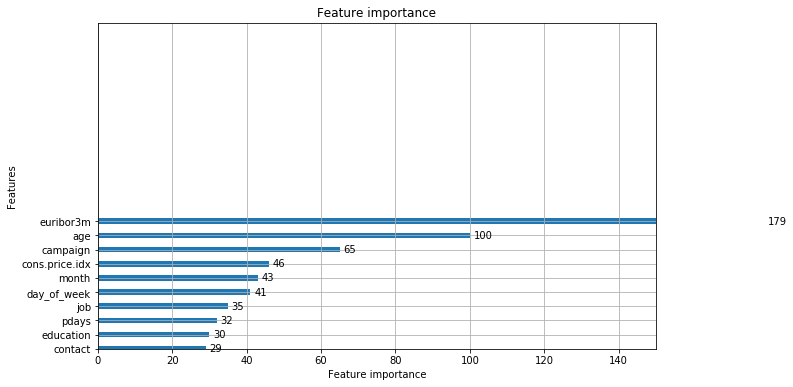

In [58]:
#Dimensionality reduction using feature importances
#features importance graph
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25,
                         ylabel='Features',
                         xlim = (0,150), ylim = (0,23), 
                         figsize = (10,6))
plt.show()

In [59]:
# For each feature of our dataset, the result of the following
# code snippet contains numbers of times a feature is used in a model.
sorted(gbm.feature_importances_,reverse=True)

[179, 100, 65, 46, 43, 41, 35, 32, 30, 29]

In [60]:
# The code below aims to find where at least 85% 
temp = 0 
total = sum(gbm.feature_importances_)
for feature in sorted(gbm.feature_importances_, reverse=True):
    temp+=feature
    if temp/total >= 0.85:
        print(feature,temp/total) # stop when we 
        break

32 0.9016666666666666


In [61]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
auc_roc_0=str(roc_auc_score(y_test, y_pred_prob)) # store AUC score without dimensionality reduction
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC without dimensionality reduction: 
0.8059632144089304


In [62]:
#Drop features to reduce dimensionality to save training time and space

X = X.drop(['marital','housing','loan','emp.var.rate','previous','default','nr.employed', 'cons.conf.idx','nr.employed','poutcome'], axis=1)


KeyError: "['marital' 'housing' 'loan' 'emp.var.rate' 'previous' 'default'\n 'nr.employed' 'cons.conf.idx' 'nr.employed' 'poutcome'] not found in axis"

In [54]:
#print(X)

In [52]:
# Remake our test/train set with our reduced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)

reduc_estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}

gridsearch = GridSearchCV(reduc_estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)
print('Best parameters found by grid search are:', gridsearch.best_params_)

C:\Users\barba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.330691	valid_0's l1: 0.195063
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782418	valid_0's binary_logloss: 0.31845	valid_0's l1: 0.190964
[3]	valid_0's auc: 0.781235	valid_0's binary_logloss: 0.309569	valid_0's l1: 0.187304
[4]	valid_0's auc: 0.78379	valid_0's binary_logloss: 0.30285	valid_0's l1: 0.183966
[5]	valid_0's auc: 0.784247	valid_0's binary_logloss: 0.297875	valid_0's l1: 0.181052
[6]	valid_0's auc: 0.785136	valid_0's binary_logloss: 0.293832	valid_0's l1: 0.178367
[7]	valid_0's auc: 0.785997	valid_0's binary_logloss: 0.290458	valid_0's l1: 0.17595
[8]	valid_0's auc: 0.786131	valid_0's binary_logloss: 0.287732	valid_0's l1: 0.173762
[9]	valid_0's auc: 0.786873	valid_0's binary_logloss: 0.285671	valid_0's l1: 0.171887
[10]	valid_0's auc: 0.793182	valid_0's binary_logloss: 0.283272	valid_0's l1: 0.169967
[11]	valid_0's auc: 0.795578	valid_0's binary_logloss: 0.281458	valid_0's l1: 0.16

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.330902	valid_0's l1: 0.194978
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.781697	valid_0's binary_logloss: 0.318392	valid_0's l1: 0.190798
[3]	valid_0's auc: 0.78453	valid_0's binary_logloss: 0.309084	valid_0's l1: 0.186962
[4]	valid_0's auc: 0.785098	valid_0's binary_logloss: 0.302453	valid_0's l1: 0.183626
[5]	valid_0's auc: 0.784953	valid_0's binary_logloss: 0.297225	valid_0's l1: 0.180618
[6]	valid_0's auc: 0.785931	valid_0's binary_logloss: 0.293014	valid_0's l1: 0.177883
[7]	valid_0's auc: 0.785746	valid_0's binary_logloss: 0.289757	valid_0's l1: 0.175414
[8]	valid_0's auc: 0.788001	valid_0's binary_logloss: 0.287168	valid_0's l1: 0.173262
[9]	valid_0's auc: 0.793849	valid_0's binary_logloss: 0.284856	valid_0's l1: 0.171352
[10]	valid_0's auc: 0.796689	valid_0's binary_logloss: 0.282613	valid_0's l1: 0.169491
[11]	valid_0's auc: 0.796965	valid_0's binary_logloss: 0.281098	valid_0's l1: 0

[1]	valid_0's auc: 0.784666	valid_0's binary_logloss: 0.33002	valid_0's l1: 0.194748
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.789168	valid_0's binary_logloss: 0.317168	valid_0's l1: 0.190412
[3]	valid_0's auc: 0.785666	valid_0's binary_logloss: 0.308086	valid_0's l1: 0.186539
[4]	valid_0's auc: 0.784769	valid_0's binary_logloss: 0.301091	valid_0's l1: 0.183033
[5]	valid_0's auc: 0.787233	valid_0's binary_logloss: 0.295766	valid_0's l1: 0.17992
[6]	valid_0's auc: 0.796199	valid_0's binary_logloss: 0.291295	valid_0's l1: 0.177185
[7]	valid_0's auc: 0.797189	valid_0's binary_logloss: 0.287911	valid_0's l1: 0.174654
[8]	valid_0's auc: 0.798745	valid_0's binary_logloss: 0.284951	valid_0's l1: 0.172359
[9]	valid_0's auc: 0.800333	valid_0's binary_logloss: 0.282278	valid_0's l1: 0.170259
[10]	valid_0's auc: 0.799956	valid_0's binary_logloss: 0.28053	valid_0's l1: 0.168405
[11]	valid_0's auc: 0.800736	valid_0's binary_logloss: 0.279038	valid_0's l1: 0.1

[1]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.330691	valid_0's l1: 0.195063
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782418	valid_0's binary_logloss: 0.31845	valid_0's l1: 0.190964
[3]	valid_0's auc: 0.781235	valid_0's binary_logloss: 0.309569	valid_0's l1: 0.187304
[4]	valid_0's auc: 0.78379	valid_0's binary_logloss: 0.30285	valid_0's l1: 0.183966
[5]	valid_0's auc: 0.784247	valid_0's binary_logloss: 0.297875	valid_0's l1: 0.181052
[6]	valid_0's auc: 0.785136	valid_0's binary_logloss: 0.293832	valid_0's l1: 0.178367
[7]	valid_0's auc: 0.785997	valid_0's binary_logloss: 0.290458	valid_0's l1: 0.17595
[8]	valid_0's auc: 0.786131	valid_0's binary_logloss: 0.287732	valid_0's l1: 0.173762
[9]	valid_0's auc: 0.786873	valid_0's binary_logloss: 0.285671	valid_0's l1: 0.171887
[10]	valid_0's auc: 0.793182	valid_0's binary_logloss: 0.283272	valid_0's l1: 0.169967
[11]	valid_0's auc: 0.795578	valid_0's binary_logloss: 0.281458	valid_0's l1: 0.16

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.330902	valid_0's l1: 0.194978
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.781697	valid_0's binary_logloss: 0.318392	valid_0's l1: 0.190798
[3]	valid_0's auc: 0.78453	valid_0's binary_logloss: 0.309084	valid_0's l1: 0.186962
[4]	valid_0's auc: 0.785098	valid_0's binary_logloss: 0.302453	valid_0's l1: 0.183626
[5]	valid_0's auc: 0.784953	valid_0's binary_logloss: 0.297225	valid_0's l1: 0.180618
[6]	valid_0's auc: 0.785931	valid_0's binary_logloss: 0.293014	valid_0's l1: 0.177883
[7]	valid_0's auc: 0.785746	valid_0's binary_logloss: 0.289757	valid_0's l1: 0.175414
[8]	valid_0's auc: 0.788001	valid_0's binary_logloss: 0.287168	valid_0's l1: 0.173262
[9]	valid_0's auc: 0.793849	valid_0's binary_logloss: 0.284856	valid_0's l1: 0.171352
[10]	valid_0's auc: 0.796689	valid_0's binary_logloss: 0.282613	valid_0's l1: 0.169491
[11]	valid_0's auc: 0.796965	valid_0's binary_logloss: 0.281098	valid_0's l1: 0

[1]	valid_0's auc: 0.784666	valid_0's binary_logloss: 0.325106	valid_0's l1: 0.193457
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.789845	valid_0's binary_logloss: 0.311388	valid_0's l1: 0.188275
[3]	valid_0's auc: 0.787671	valid_0's binary_logloss: 0.301772	valid_0's l1: 0.183674
[4]	valid_0's auc: 0.787706	valid_0's binary_logloss: 0.295127	valid_0's l1: 0.179764
[5]	valid_0's auc: 0.797668	valid_0's binary_logloss: 0.289597	valid_0's l1: 0.17624
[6]	valid_0's auc: 0.798401	valid_0's binary_logloss: 0.285765	valid_0's l1: 0.173238
[7]	valid_0's auc: 0.800085	valid_0's binary_logloss: 0.282509	valid_0's l1: 0.170549
[8]	valid_0's auc: 0.801038	valid_0's binary_logloss: 0.279943	valid_0's l1: 0.168119
[9]	valid_0's auc: 0.802431	valid_0's binary_logloss: 0.278102	valid_0's l1: 0.166131
[10]	valid_0's auc: 0.802348	valid_0's binary_logloss: 0.276591	valid_0's l1: 0.164303
[11]	valid_0's auc: 0.801888	valid_0's binary_logloss: 0.275471	valid_0's l1: 0

[1]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.325936	valid_0's l1: 0.193876
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.780969	valid_0's binary_logloss: 0.312556	valid_0's l1: 0.18892
[3]	valid_0's auc: 0.781792	valid_0's binary_logloss: 0.303555	valid_0's l1: 0.184619
[4]	valid_0's auc: 0.782922	valid_0's binary_logloss: 0.29719	valid_0's l1: 0.180913
[5]	valid_0's auc: 0.783907	valid_0's binary_logloss: 0.292283	valid_0's l1: 0.177587
[6]	valid_0's auc: 0.784147	valid_0's binary_logloss: 0.288555	valid_0's l1: 0.17466
[7]	valid_0's auc: 0.786793	valid_0's binary_logloss: 0.285508	valid_0's l1: 0.17223
[8]	valid_0's auc: 0.783853	valid_0's binary_logloss: 0.283548	valid_0's l1: 0.170041
[9]	valid_0's auc: 0.791912	valid_0's binary_logloss: 0.281451	valid_0's l1: 0.168173
[10]	valid_0's auc: 0.794343	valid_0's binary_logloss: 0.279884	valid_0's l1: 0.166487
[11]	valid_0's auc: 0.795681	valid_0's binary_logloss: 0.278738	valid_0's l1: 0.16

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.326178	valid_0's l1: 0.193766
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.78174	valid_0's binary_logloss: 0.312479	valid_0's l1: 0.188714
[3]	valid_0's auc: 0.783877	valid_0's binary_logloss: 0.303192	valid_0's l1: 0.184367
[4]	valid_0's auc: 0.783978	valid_0's binary_logloss: 0.296772	valid_0's l1: 0.180586
[5]	valid_0's auc: 0.786801	valid_0's binary_logloss: 0.291653	valid_0's l1: 0.177184
[6]	valid_0's auc: 0.786984	valid_0's binary_logloss: 0.287789	valid_0's l1: 0.174184
[7]	valid_0's auc: 0.788657	valid_0's binary_logloss: 0.284978	valid_0's l1: 0.171618
[8]	valid_0's auc: 0.794528	valid_0's binary_logloss: 0.282429	valid_0's l1: 0.169378
[9]	valid_0's auc: 0.798243	valid_0's binary_logloss: 0.280549	valid_0's l1: 0.167425
[10]	valid_0's auc: 0.79807	valid_0's binary_logloss: 0.279323	valid_0's l1: 0.16575
[11]	valid_0's auc: 0.797251	valid_0's binary_logloss: 0.27833	valid_0's l1: 0.16

[1]	valid_0's auc: 0.784666	valid_0's binary_logloss: 0.325106	valid_0's l1: 0.193457
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.789845	valid_0's binary_logloss: 0.311388	valid_0's l1: 0.188275
[3]	valid_0's auc: 0.787671	valid_0's binary_logloss: 0.301772	valid_0's l1: 0.183674
[4]	valid_0's auc: 0.787706	valid_0's binary_logloss: 0.295127	valid_0's l1: 0.179764
[5]	valid_0's auc: 0.797668	valid_0's binary_logloss: 0.289597	valid_0's l1: 0.17624
[6]	valid_0's auc: 0.798401	valid_0's binary_logloss: 0.285765	valid_0's l1: 0.173238
[7]	valid_0's auc: 0.800085	valid_0's binary_logloss: 0.282509	valid_0's l1: 0.170549
[8]	valid_0's auc: 0.801038	valid_0's binary_logloss: 0.279943	valid_0's l1: 0.168119
[9]	valid_0's auc: 0.802431	valid_0's binary_logloss: 0.278102	valid_0's l1: 0.166131
[10]	valid_0's auc: 0.802348	valid_0's binary_logloss: 0.276591	valid_0's l1: 0.164303
[11]	valid_0's auc: 0.801888	valid_0's binary_logloss: 0.275471	valid_0's l1: 0

[1]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.325936	valid_0's l1: 0.193876
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.780969	valid_0's binary_logloss: 0.312556	valid_0's l1: 0.18892
[3]	valid_0's auc: 0.781792	valid_0's binary_logloss: 0.303555	valid_0's l1: 0.184619
[4]	valid_0's auc: 0.782922	valid_0's binary_logloss: 0.29719	valid_0's l1: 0.180913
[5]	valid_0's auc: 0.783907	valid_0's binary_logloss: 0.292283	valid_0's l1: 0.177587
[6]	valid_0's auc: 0.784147	valid_0's binary_logloss: 0.288555	valid_0's l1: 0.17466
[7]	valid_0's auc: 0.786793	valid_0's binary_logloss: 0.285508	valid_0's l1: 0.17223
[8]	valid_0's auc: 0.783853	valid_0's binary_logloss: 0.283548	valid_0's l1: 0.170041
[9]	valid_0's auc: 0.791912	valid_0's binary_logloss: 0.281451	valid_0's l1: 0.168173
[10]	valid_0's auc: 0.794343	valid_0's binary_logloss: 0.279884	valid_0's l1: 0.166487
[11]	valid_0's auc: 0.795681	valid_0's binary_logloss: 0.278738	valid_0's l1: 0.16

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.321649	valid_0's l1: 0.192546
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.781787	valid_0's binary_logloss: 0.30748	valid_0's l1: 0.186717
[3]	valid_0's auc: 0.784903	valid_0's binary_logloss: 0.298392	valid_0's l1: 0.181765
[4]	valid_0's auc: 0.7883	valid_0's binary_logloss: 0.291881	valid_0's l1: 0.177538
[5]	valid_0's auc: 0.786925	valid_0's binary_logloss: 0.287544	valid_0's l1: 0.173989
[6]	valid_0's auc: 0.78836	valid_0's binary_logloss: 0.284466	valid_0's l1: 0.171046
[7]	valid_0's auc: 0.794009	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.168399
[8]	valid_0's auc: 0.798227	valid_0's binary_logloss: 0.279198	valid_0's l1: 0.166121
[9]	valid_0's auc: 0.799007	valid_0's binary_logloss: 0.277937	valid_0's l1: 0.164289
[10]	valid_0's auc: 0.796469	valid_0's binary_logloss: 0.276934	valid_0's l1: 0.162762
[11]	valid_0's auc: 0.796406	valid_0's binary_logloss: 0.276148	valid_0's l1: 0.16

[1]	valid_0's auc: 0.784666	valid_0's binary_logloss: 0.320405	valid_0's l1: 0.192151
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782668	valid_0's binary_logloss: 0.305835	valid_0's l1: 0.18616
[3]	valid_0's auc: 0.784222	valid_0's binary_logloss: 0.296295	valid_0's l1: 0.180976
[4]	valid_0's auc: 0.790338	valid_0's binary_logloss: 0.289766	valid_0's l1: 0.176622
[5]	valid_0's auc: 0.797741	valid_0's binary_logloss: 0.285538	valid_0's l1: 0.173157
[6]	valid_0's auc: 0.800393	valid_0's binary_logloss: 0.281741	valid_0's l1: 0.169975
[7]	valid_0's auc: 0.801018	valid_0's binary_logloss: 0.278956	valid_0's l1: 0.167251
[8]	valid_0's auc: 0.801719	valid_0's binary_logloss: 0.277153	valid_0's l1: 0.165018
[9]	valid_0's auc: 0.800659	valid_0's binary_logloss: 0.275935	valid_0's l1: 0.163054
[10]	valid_0's auc: 0.799951	valid_0's binary_logloss: 0.274883	valid_0's l1: 0.161261
[11]	valid_0's auc: 0.80176	valid_0's binary_logloss: 0.274156	valid_0's l1: 0.

[1]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.321389	valid_0's l1: 0.192681
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.780775	valid_0's binary_logloss: 0.307495	valid_0's l1: 0.186963
[3]	valid_0's auc: 0.785922	valid_0's binary_logloss: 0.298321	valid_0's l1: 0.182054
[4]	valid_0's auc: 0.785628	valid_0's binary_logloss: 0.292424	valid_0's l1: 0.178083
[5]	valid_0's auc: 0.785323	valid_0's binary_logloss: 0.287882	valid_0's l1: 0.174528
[6]	valid_0's auc: 0.787125	valid_0's binary_logloss: 0.284623	valid_0's l1: 0.171505
[7]	valid_0's auc: 0.784648	valid_0's binary_logloss: 0.282115	valid_0's l1: 0.168789
[8]	valid_0's auc: 0.787532	valid_0's binary_logloss: 0.280346	valid_0's l1: 0.166623
[9]	valid_0's auc: 0.788545	valid_0's binary_logloss: 0.27896	valid_0's l1: 0.16478
[10]	valid_0's auc: 0.790822	valid_0's binary_logloss: 0.277848	valid_0's l1: 0.163162
[11]	valid_0's auc: 0.795747	valid_0's binary_logloss: 0.27641	valid_0's l1: 0.1

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.321649	valid_0's l1: 0.192546
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.781787	valid_0's binary_logloss: 0.30748	valid_0's l1: 0.186717
[3]	valid_0's auc: 0.784903	valid_0's binary_logloss: 0.298392	valid_0's l1: 0.181765
[4]	valid_0's auc: 0.7883	valid_0's binary_logloss: 0.291881	valid_0's l1: 0.177538
[5]	valid_0's auc: 0.786925	valid_0's binary_logloss: 0.287544	valid_0's l1: 0.173989
[6]	valid_0's auc: 0.78836	valid_0's binary_logloss: 0.284466	valid_0's l1: 0.171046
[7]	valid_0's auc: 0.794009	valid_0's binary_logloss: 0.281588	valid_0's l1: 0.168399
[8]	valid_0's auc: 0.798227	valid_0's binary_logloss: 0.279198	valid_0's l1: 0.166121
[9]	valid_0's auc: 0.799007	valid_0's binary_logloss: 0.277937	valid_0's l1: 0.164289
[10]	valid_0's auc: 0.796469	valid_0's binary_logloss: 0.276934	valid_0's l1: 0.162762
[11]	valid_0's auc: 0.796406	valid_0's binary_logloss: 0.276148	valid_0's l1: 0.16

[1]	valid_0's auc: 0.784666	valid_0's binary_logloss: 0.320405	valid_0's l1: 0.192151
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782668	valid_0's binary_logloss: 0.305835	valid_0's l1: 0.18616
[3]	valid_0's auc: 0.784222	valid_0's binary_logloss: 0.296295	valid_0's l1: 0.180976
[4]	valid_0's auc: 0.790338	valid_0's binary_logloss: 0.289766	valid_0's l1: 0.176622
[5]	valid_0's auc: 0.797741	valid_0's binary_logloss: 0.285538	valid_0's l1: 0.173157
[6]	valid_0's auc: 0.800393	valid_0's binary_logloss: 0.281741	valid_0's l1: 0.169975
[7]	valid_0's auc: 0.801018	valid_0's binary_logloss: 0.278956	valid_0's l1: 0.167251
[8]	valid_0's auc: 0.801719	valid_0's binary_logloss: 0.277153	valid_0's l1: 0.165018
[9]	valid_0's auc: 0.800659	valid_0's binary_logloss: 0.275935	valid_0's l1: 0.163054
[10]	valid_0's auc: 0.799951	valid_0's binary_logloss: 0.274883	valid_0's l1: 0.161261
[11]	valid_0's auc: 0.80176	valid_0's binary_logloss: 0.274156	valid_0's l1: 0.

[1]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.317063	valid_0's l1: 0.191479
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.780806	valid_0's binary_logloss: 0.302976	valid_0's l1: 0.185107
[3]	valid_0's auc: 0.783374	valid_0's binary_logloss: 0.2945	valid_0's l1: 0.179906
[4]	valid_0's auc: 0.784917	valid_0's binary_logloss: 0.289061	valid_0's l1: 0.175625
[5]	valid_0's auc: 0.787141	valid_0's binary_logloss: 0.285165	valid_0's l1: 0.171957
[6]	valid_0's auc: 0.794395	valid_0's binary_logloss: 0.281721	valid_0's l1: 0.168866
[7]	valid_0's auc: 0.797164	valid_0's binary_logloss: 0.27975	valid_0's l1: 0.166417
[8]	valid_0's auc: 0.796344	valid_0's binary_logloss: 0.278319	valid_0's l1: 0.164265
[9]	valid_0's auc: 0.79552	valid_0's binary_logloss: 0.277502	valid_0's l1: 0.162573
[10]	valid_0's auc: 0.794956	valid_0's binary_logloss: 0.276889	valid_0's l1: 0.161124
[11]	valid_0's auc: 0.798198	valid_0's binary_logloss: 0.275727	valid_0's l1: 0.15

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.31733	valid_0's l1: 0.19132
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782931	valid_0's binary_logloss: 0.302777	valid_0's l1: 0.184738
[3]	valid_0's auc: 0.784607	valid_0's binary_logloss: 0.294462	valid_0's l1: 0.179422
[4]	valid_0's auc: 0.785382	valid_0's binary_logloss: 0.288823	valid_0's l1: 0.175032
[5]	valid_0's auc: 0.789485	valid_0's binary_logloss: 0.284984	valid_0's l1: 0.171535
[6]	valid_0's auc: 0.795624	valid_0's binary_logloss: 0.281941	valid_0's l1: 0.168499
[7]	valid_0's auc: 0.799361	valid_0's binary_logloss: 0.279321	valid_0's l1: 0.165864
[8]	valid_0's auc: 0.79896	valid_0's binary_logloss: 0.277842	valid_0's l1: 0.163764
[9]	valid_0's auc: 0.799627	valid_0's binary_logloss: 0.276968	valid_0's l1: 0.161981
[10]	valid_0's auc: 0.799098	valid_0's binary_logloss: 0.275986	valid_0's l1: 0.16044
[11]	valid_0's auc: 0.799959	valid_0's binary_logloss: 0.275201	valid_0's l1: 0.15

[1]	valid_0's auc: 0.784666	valid_0's binary_logloss: 0.31593	valid_0's l1: 0.190832
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783223	valid_0's binary_logloss: 0.300917	valid_0's l1: 0.184023
[3]	valid_0's auc: 0.786464	valid_0's binary_logloss: 0.292033	valid_0's l1: 0.178558
[4]	valid_0's auc: 0.796645	valid_0's binary_logloss: 0.285268	valid_0's l1: 0.173808
[5]	valid_0's auc: 0.799824	valid_0's binary_logloss: 0.281524	valid_0's l1: 0.170106
[6]	valid_0's auc: 0.80001	valid_0's binary_logloss: 0.27839	valid_0's l1: 0.166848
[7]	valid_0's auc: 0.800572	valid_0's binary_logloss: 0.27642	valid_0's l1: 0.164332
[8]	valid_0's auc: 0.80071	valid_0's binary_logloss: 0.274857	valid_0's l1: 0.162156
[9]	valid_0's auc: 0.800019	valid_0's binary_logloss: 0.274232	valid_0's l1: 0.160496
[10]	valid_0's auc: 0.800543	valid_0's binary_logloss: 0.273485	valid_0's l1: 0.158897
[11]	valid_0's auc: 0.80084	valid_0's binary_logloss: 0.27291	valid_0's l1: 0.15759

[1]	valid_0's auc: 0.782639	valid_0's binary_logloss: 0.317063	valid_0's l1: 0.191479
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.780806	valid_0's binary_logloss: 0.302976	valid_0's l1: 0.185107
[3]	valid_0's auc: 0.783374	valid_0's binary_logloss: 0.2945	valid_0's l1: 0.179906
[4]	valid_0's auc: 0.784917	valid_0's binary_logloss: 0.289061	valid_0's l1: 0.175625
[5]	valid_0's auc: 0.787141	valid_0's binary_logloss: 0.285165	valid_0's l1: 0.171957
[6]	valid_0's auc: 0.794395	valid_0's binary_logloss: 0.281721	valid_0's l1: 0.168866
[7]	valid_0's auc: 0.797164	valid_0's binary_logloss: 0.27975	valid_0's l1: 0.166417
[8]	valid_0's auc: 0.796344	valid_0's binary_logloss: 0.278319	valid_0's l1: 0.164265
[9]	valid_0's auc: 0.79552	valid_0's binary_logloss: 0.277502	valid_0's l1: 0.162573
[10]	valid_0's auc: 0.794956	valid_0's binary_logloss: 0.276889	valid_0's l1: 0.161124
[11]	valid_0's auc: 0.798198	valid_0's binary_logloss: 0.275727	valid_0's l1: 0.15

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.31733	valid_0's l1: 0.19132
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.782931	valid_0's binary_logloss: 0.302777	valid_0's l1: 0.184738
[3]	valid_0's auc: 0.784607	valid_0's binary_logloss: 0.294462	valid_0's l1: 0.179422
[4]	valid_0's auc: 0.785382	valid_0's binary_logloss: 0.288823	valid_0's l1: 0.175032
[5]	valid_0's auc: 0.789485	valid_0's binary_logloss: 0.284984	valid_0's l1: 0.171535
[6]	valid_0's auc: 0.795624	valid_0's binary_logloss: 0.281941	valid_0's l1: 0.168499
[7]	valid_0's auc: 0.799361	valid_0's binary_logloss: 0.279321	valid_0's l1: 0.165864
[8]	valid_0's auc: 0.79896	valid_0's binary_logloss: 0.277842	valid_0's l1: 0.163764
[9]	valid_0's auc: 0.799627	valid_0's binary_logloss: 0.276968	valid_0's l1: 0.161981
[10]	valid_0's auc: 0.799098	valid_0's binary_logloss: 0.275986	valid_0's l1: 0.16044
[11]	valid_0's auc: 0.799959	valid_0's binary_logloss: 0.275201	valid_0's l1: 0.15

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.313233	valid_0's l1: 0.190089
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.78295	valid_0's binary_logloss: 0.298859	valid_0's l1: 0.18307
[3]	valid_0's auc: 0.783134	valid_0's binary_logloss: 0.291032	valid_0's l1: 0.177441
[4]	valid_0's auc: 0.785833	valid_0's binary_logloss: 0.285905	valid_0's l1: 0.172805
[5]	valid_0's auc: 0.793354	valid_0's binary_logloss: 0.282202	valid_0's l1: 0.16915
[6]	valid_0's auc: 0.792449	valid_0's binary_logloss: 0.279992	valid_0's l1: 0.166025
[7]	valid_0's auc: 0.798418	valid_0's binary_logloss: 0.277807	valid_0's l1: 0.163456
[8]	valid_0's auc: 0.797789	valid_0's binary_logloss: 0.276562	valid_0's l1: 0.161323
[9]	valid_0's auc: 0.797304	valid_0's binary_logloss: 0.276064	valid_0's l1: 0.159719
[10]	valid_0's auc: 0.797444	valid_0's binary_logloss: 0.275313	valid_0's l1: 0.158547
[11]	valid_0's auc: 0.796808	valid_0's binary_logloss: 0.274925	valid_0's l1: 0.1

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.313233	valid_0's l1: 0.190089
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.78295	valid_0's binary_logloss: 0.298859	valid_0's l1: 0.18307
[3]	valid_0's auc: 0.783134	valid_0's binary_logloss: 0.291032	valid_0's l1: 0.177441
[4]	valid_0's auc: 0.785833	valid_0's binary_logloss: 0.285905	valid_0's l1: 0.172805
[5]	valid_0's auc: 0.793354	valid_0's binary_logloss: 0.282202	valid_0's l1: 0.16915
[6]	valid_0's auc: 0.792449	valid_0's binary_logloss: 0.279992	valid_0's l1: 0.166025
[7]	valid_0's auc: 0.798418	valid_0's binary_logloss: 0.277807	valid_0's l1: 0.163456
[8]	valid_0's auc: 0.797789	valid_0's binary_logloss: 0.276562	valid_0's l1: 0.161323
[9]	valid_0's auc: 0.797304	valid_0's binary_logloss: 0.276064	valid_0's l1: 0.159719
[10]	valid_0's auc: 0.797444	valid_0's binary_logloss: 0.275313	valid_0's l1: 0.158547
[11]	valid_0's auc: 0.796808	valid_0's binary_logloss: 0.274925	valid_0's l1: 0.1

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.313233	valid_0's l1: 0.190089
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.78295	valid_0's binary_logloss: 0.298859	valid_0's l1: 0.18307
[3]	valid_0's auc: 0.783134	valid_0's binary_logloss: 0.291032	valid_0's l1: 0.177441
[4]	valid_0's auc: 0.785833	valid_0's binary_logloss: 0.285905	valid_0's l1: 0.172805
[5]	valid_0's auc: 0.793354	valid_0's binary_logloss: 0.282202	valid_0's l1: 0.16915
[6]	valid_0's auc: 0.792449	valid_0's binary_logloss: 0.279992	valid_0's l1: 0.166025
[7]	valid_0's auc: 0.798418	valid_0's binary_logloss: 0.277807	valid_0's l1: 0.163456
[8]	valid_0's auc: 0.797789	valid_0's binary_logloss: 0.276562	valid_0's l1: 0.161323
[9]	valid_0's auc: 0.797304	valid_0's binary_logloss: 0.276064	valid_0's l1: 0.159719
[10]	valid_0's auc: 0.797444	valid_0's binary_logloss: 0.275313	valid_0's l1: 0.158547
[11]	valid_0's auc: 0.796808	valid_0's binary_logloss: 0.274925	valid_0's l1: 0.1

[1]	valid_0's auc: 0.780714	valid_0's binary_logloss: 0.313233	valid_0's l1: 0.190089
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.78295	valid_0's binary_logloss: 0.298859	valid_0's l1: 0.18307
[3]	valid_0's auc: 0.783134	valid_0's binary_logloss: 0.291032	valid_0's l1: 0.177441
[4]	valid_0's auc: 0.785833	valid_0's binary_logloss: 0.285905	valid_0's l1: 0.172805
[5]	valid_0's auc: 0.793354	valid_0's binary_logloss: 0.282202	valid_0's l1: 0.16915
[6]	valid_0's auc: 0.792449	valid_0's binary_logloss: 0.279992	valid_0's l1: 0.166025
[7]	valid_0's auc: 0.798418	valid_0's binary_logloss: 0.277807	valid_0's l1: 0.163456
[8]	valid_0's auc: 0.797789	valid_0's binary_logloss: 0.276562	valid_0's l1: 0.161323
[9]	valid_0's auc: 0.797304	valid_0's binary_logloss: 0.276064	valid_0's l1: 0.159719
[10]	valid_0's auc: 0.797444	valid_0's binary_logloss: 0.275313	valid_0's l1: 0.158547
[11]	valid_0's auc: 0.796808	valid_0's binary_logloss: 0.274925	valid_0's l1: 0.1

In [29]:
gbm = lgb.LGBMClassifier(learning_rate = 0.15, metric = 'l1', 
                        n_estimators = 20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's auc: 0.783366	valid_0's binary_logloss: 0.321751	valid_0's l1: 0.192525
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.783984	valid_0's binary_logloss: 0.307403	valid_0's l1: 0.186573
[3]	valid_0's auc: 0.785909	valid_0's binary_logloss: 0.298048	valid_0's l1: 0.181617
[4]	valid_0's auc: 0.788834	valid_0's binary_logloss: 0.291544	valid_0's l1: 0.177389
[5]	valid_0's auc: 0.790206	valid_0's binary_logloss: 0.287032	valid_0's l1: 0.17389
[6]	valid_0's auc: 0.795838	valid_0's binary_logloss: 0.283031	valid_0's l1: 0.17075
[7]	valid_0's auc: 0.795765	valid_0's binary_logloss: 0.280275	valid_0's l1: 0.167976
[8]	valid_0's auc: 0.797283	valid_0's binary_logloss: 0.278101	valid_0's l1: 0.165772
[9]	valid_0's auc: 0.798372	valid_0's binary_logloss: 0.276447	valid_0's l1: 0.163742
[10]	valid_0's auc: 0.798334	valid_0's binary_logloss: 0.275193	valid_0's l1: 0.161892
[11]	valid_0's auc: 0.798831	valid_0's binary_logloss: 0.274343	valid_0's l1: 0.

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.15, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [30]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))

The accuracy of prediction is: 0.9041029376062151
The roc_auc_score of prediction is: 0.6102170579088904
The null acccuracy is: 0.8875940762320952


In [31]:
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
y_pred_prob

array([0.07632906, 0.02980122, 0.04506656, ..., 0.12342936, 0.12026791,
       0.06087949])

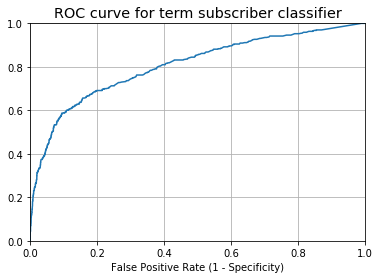

In [32]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for term subscriber classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [33]:
auc_roc_1 = str(roc_auc_score(y_test, y_pred_prob))
print('AUC with dimensionality reduction: \n' + auc_roc_1)
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC with dimensionality reduction: 
0.8066609047643803
AUC without dimensionality reduction: 
0.7977937429536279


In [34]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

#Basic terminology

#True Positives (TP): we correctly predicted that they would default.
#262
#True Negatives (TN): we correctly predicted that they won't default.
#3538
#False Positives (FP): we incorrectly predicted that they did default.
#118
#Falsely predict positive
#Type I error
#False Negatives (FN): we incorrectly predicted that they didn't default.
#201
#Falsely predict negative
#Type II error

[[3617   39]
 [ 356  107]]


In [35]:
score = gbm.score(X_test, y_test)
print(score)

0.9041029376062151
